Shadeeb Hossain [ORCID ID :0000-0002-5224-7684]

In [ ]:

! pip install flickrapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 1.0 MB/s eta 0:00:00


In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5006018395001502890
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14410383360
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12537885412285857060
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


**Import Standard Libraries for FlickrAPI**

In [ ]:
import flickrapi
import urllib.request
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import requests
from io import BytesIO
%matplotlib inline

**Accessing FlickrAPI**

In [ ]:
# see the flickr demo on where to get keys.
api_key = u'xxxxxxxxxxxxxxxxxxxxxx'
api_secret = u'xxxxxxxxxxxxxxxxxxxxx'
flickr = flickrapi.FlickrAPI(api_key, api_secret)

**Creating Directories for Train and Test**

In [ ]:
import warnings
import os
dir_name = 'train'
dir_exists = os.path.isdir(dir_name)
if not dir_exists:
    os.mkdir(dir_name)
    print("Making directory %s" % dir_name)
else:
    print("Will store images in directory %s" % dir_name)

dir_name = 'test'
dir_exists = os.path.isdir(dir_name)
if not dir_exists:
    os.mkdir(dir_name)
    print("Making directory %s" % dir_name)
else:
    print("Will store images in directory %s" % dir_name)

dir_folder = os.path.join(os.getcwd(),'train','rotten food')
dir_exists = os.path.isdir(dir_folder)
if not dir_exists:
    os.mkdir(dir_folder)
    print("Making directory %s" % dir_folder)
else:
    print("Will store images in directory %s" % dir_folder)

dir_folder = os.path.join(os.getcwd(),'train','fresh food')
dir_exists = os.path.isdir(dir_folder)
if not dir_exists:
    os.mkdir(dir_folder)
    print("Making directory %s" % dir_folder)
else:
    print("Will store images in directory %s" % dir_folder)

dir_folder = os.path.join(os.getcwd(),'test','rotten food')
dir_exists = os.path.isdir(dir_folder)
if not dir_exists:
    os.mkdir(dir_folder)
    print("Making directory %s" % dir_folder)
else:
    print("Will store images in directory %s" % dir_folder)

dir_folder = os.path.join(os.getcwd(),'test','fresh food')
dir_exists = os.path.isdir(dir_folder)
if not dir_exists:
    os.mkdir(dir_folder)
    print("Making directory %s" % dir_folder)
else:
    print("Will store images in directory %s" % dir_folder)

Making directory train
Making directory test
Making directory /content/train/rotten food
Making directory /content/train/fresh food
Making directory /content/test/rotten food
Making directory /content/test/fresh food


**Loading a Pre-Trained Deep Network VGG16**

In [ ]:
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
import numpy as np
import matplotlib.pyplot as plt

*Clear the Keras session*

In [ ]:
from keras import backend as K
K.clear_session()

***Loading the Deep VGG16 session***

In [ ]:
nrow = 150
ncol = 150
input_shape = (nrow, ncol, 3)
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Flatten, Dense
input_shape =(nrow,ncol,3)

base_model = applications.VGG16(weights='imagenet', include_top=False,input_shape=input_shape)

58889256/58889256 [==============================] - 0s 0us/step


***Creating the Sequential model ***

In [ ]:

model = Sequential()
for layer in base_model.layers:
    model.add(layer)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(10,activation='softmax'))
for layer in model.layers:
  layer.trainable=False
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

**Model summary. It displays the number of trainable parameters vs. the non-trainable parameters.**

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 37, 37, 256)       2


***Using ImageDataGenerator to fetch images on the fly from a directory of images***.

Up to now, the training data has been represented in a large matrix. This is not possible for image data when the datasets are very large. For these applications, the keras package provides a ImageDataGenerator class that can fetch images on the fly from a directory of images. Using multi-threading, training can be performed on one mini-batch while the image reader can read files for the next mini-batch. The code below creates an ImageDataGenerator for the training data. In addition to the reading the files, the ImageDataGenerator creates random deformations of the image to expand the total dataset size. When the training data is limited, using data augmentation is very important.

In [ ]:

train_data_dir = './train'
batch_size = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        train_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')
test_data_dir = './test'
batch_size = 32
test_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_generator = test_datagen.flow_from_directory(
                        test_data_dir,
                        target_size=(nrow,ncol),
                        batch_size=batch_size,
                        class_mode='binary')

Found 1030 images belonging to 2 classes.
Found 308 images belonging to 2 classes.


**Displaying the images**

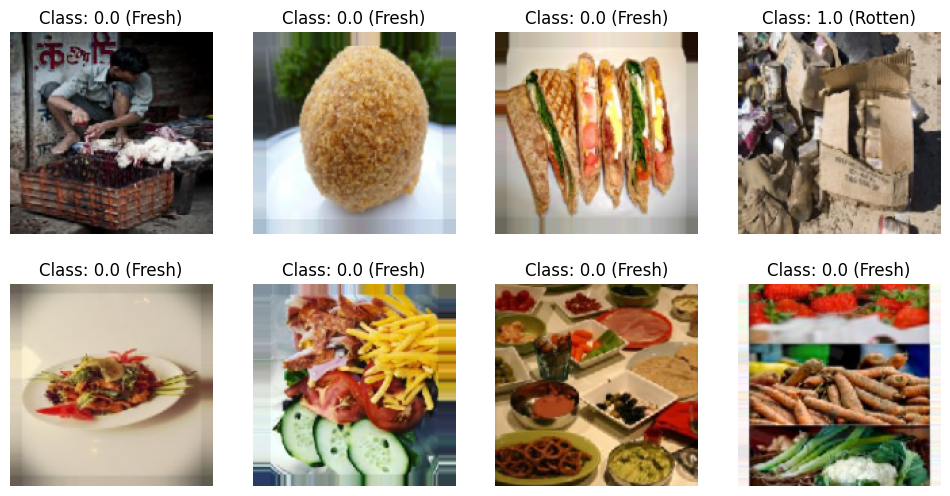

In [ ]:
def disp_image(im):
    if (len(im.shape) == 2):
        # Gray scale image
        plt.imshow(im, cmap='gray')
    else:
        # Color image.
        im1 = (im-np.min(im))/(np.max(im)-np.min(im))*255
        im1 = im1.astype(np.uint8)
        plt.imshow(im1)

    # Remove axis ticks
    plt.xticks([])
    plt.yticks([])
    X, y = train_generator.next()



import matplotlib.pyplot as plt

# Assuming train_generator is your data generator
# Make sure to set the batch_size when creating the generator

# Get a minibatch of data
X_batch, y_batch = train_generator.next()

# Display the first 8 images
num_images_to_display = 8

plt.figure(figsize=(12, 6))
for i in range(num_images_to_display):
    plt.subplot(2, 4, i + 1)
    plt.imshow(X_batch[i])
    plt.title(f'Class: {y_batch[i]} ({"Fresh" if y_batch[i] == 0 else "Rotten"})')
    plt.axis('off')

plt.show()


**Training the model**

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# Calculate steps_per_epoch and validation_steps
epochs = 10
steps_per_epoch = train_generator.n // batch_size
validation_steps = test_generator.n // batch_size

In [ ]:

nepochs = 5  # Number of epochs

# Call the fit_generator function
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=nepochs,
    validation_data=test_generator,
    validation_steps=validation_steps)

<ipython-input-34-676af86ec052>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(


Epoch 1/5
32/32 [==============================] - 9s 284ms/step - loss: 0.1351 - accuracy: 0.9709 - val_loss: 0.1264 - val_accuracy: 0.9722
Epoch 2/5
32/32 [==============================] - 10s 313ms/step - loss: 0.1358 - accuracy: 0.9709 - val_loss: 0.1267 - val_accuracy: 0.9722
Epoch 3/5
32/32 [==============================] - 11s 344ms/step - loss: 0.1341 - accuracy: 0.9709 - val_loss: 0.1265 - val_accuracy: 0.9722
Epoch 4/5
32/32 [==============================] - 12s 367ms/step - loss: 0.1354 - accuracy: 0.9699 - val_loss: 0.1265 - val_accuracy: 0.9722
Epoch 5/5
32/32 [==============================] - 18s 573ms/step - loss: 0.1352 - accuracy: 0.9699 - val_loss: 0.1146 - val_accuracy: 0.9757


Training Accuracy Vs Validation Accuracy

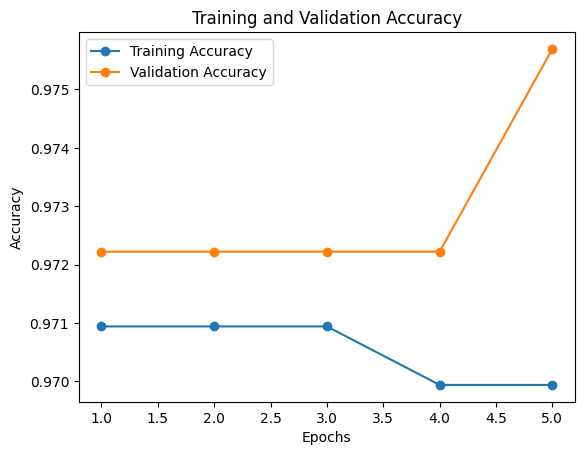

In [ ]:
import matplotlib.pyplot as plt

train_accuracy = hist.history['accuracy']
val_accuracy = hist.history['val_accuracy']

# Plot the curves
epochs = range(1, nepochs + 1)

plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
